<a href="https://colab.research.google.com/github/Darshil420/crop_disease/blob/main/crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import shutil
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50,EfficientNetB0,MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten ,GlobalAveragePooling2D ,BatchNormalization ,Dropout
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam

In [ ]:

!pip install kaggle -q

from google.colab import files

files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d arjuntejaswi/plant-village

!unzip -q plant-village.zip -d /content/PlantVillage

data_dir = "/content/PlantVillage/PlantVillage"

base_dir = "/content/plant_split"
os.makedirs(base_dir, exist_ok=True)

splits = ["train", "val", "test"]
for split in splits:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train+n_val]
    test_imgs = images[n_train+n_val:]

    for split, split_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        split_cls_path = os.path.join(base_dir, split, cls)
        os.makedirs(split_cls_path, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(cls_path, img)
            dst = os.path.join(split_cls_path, img)
            shutil.copy(src, dst)

print(" Dataset download & split completed!")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 80% 264M/329M [00:00<00:00, 621MB/s] 
100% 329M/329M [00:00<00:00, 650MB/s]
✅ Dataset download & split completed!


In [ ]:
import os
print("Current directory:", os.getcwd())
print("Files in current directory:", os.listdir('.'))

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    zoom_range = 0.1,
    shear_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 25,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
valid_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen  = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_dataset = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_dataset = valid_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_dataset = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 14440 images belonging to 15 classes.
Found 3089 images belonging to 15 classes.
Found 3109 images belonging to 15 classes.


In [ ]:
dataset_dir = "/content/PlantVillage/PlantVillage"

# Check that the folder exists
print(os.path.exists(dataset_dir))  # Should print True

# List classes
classes = sorted(os.listdir(dataset_dir))
print(f"Found classes: {classes}")

True
Found classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


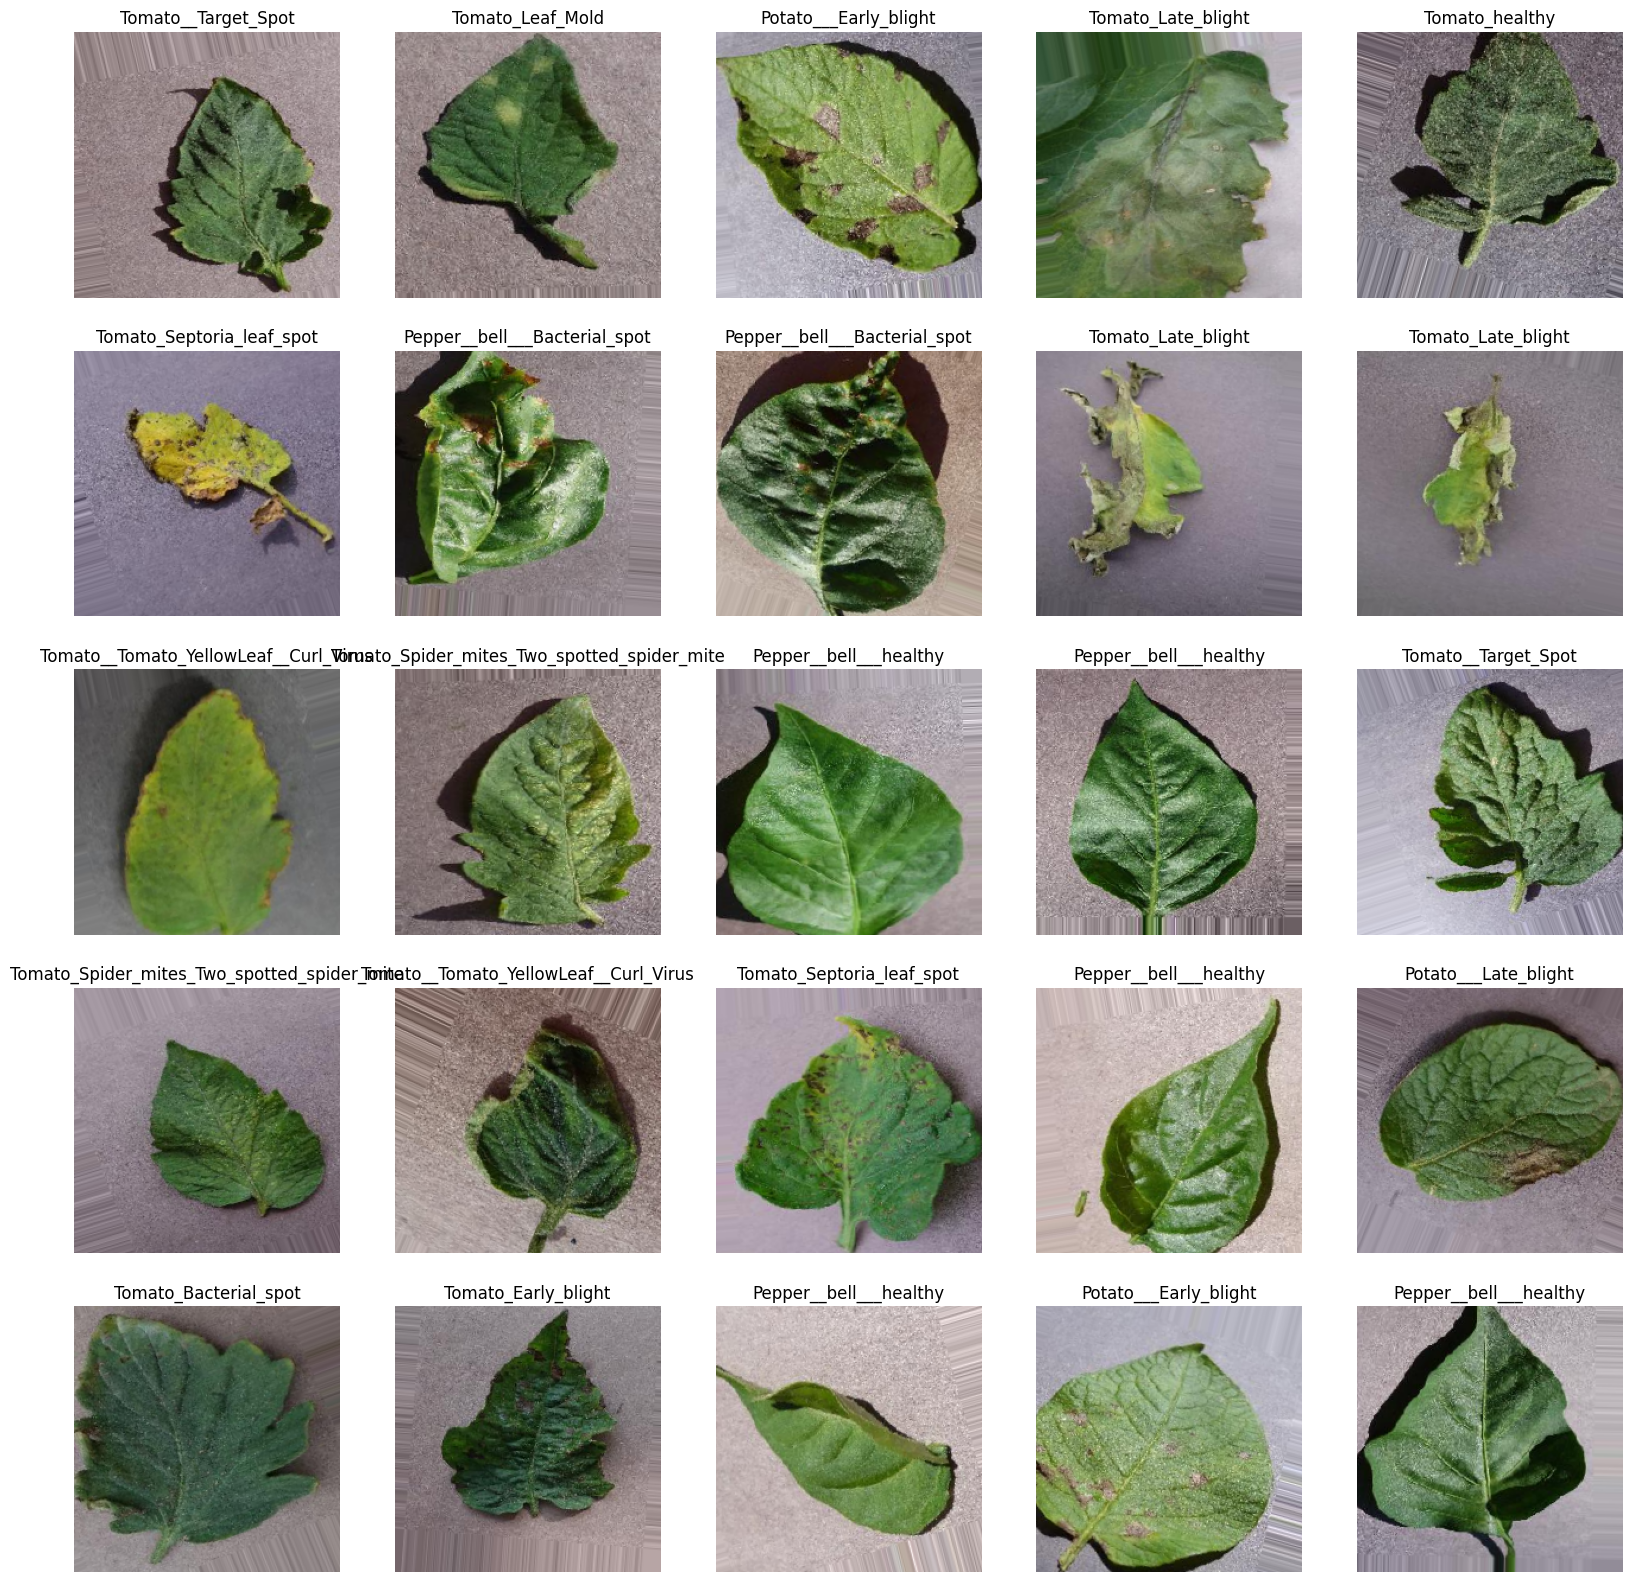

In [ ]:
x_batch, y_batch = next(train_dataset)
random_images = np.random.choice(len(x_batch), 25, replace=False)

plt.figure(figsize=(20, 20))
for n, i in enumerate(random_images):
    plt.subplot(5, 5, n+1)

    plt.imshow((x_batch[i] * 255).astype("uint8"))
    plt.axis('off')
    class_idx = np.argmax(y_batch[i])
    class_name = list(train_dataset.class_indices.keys())[class_idx]
    plt.title(class_name)
plt.show()

12    2245
5     1488
7     1336
9     1239
10    1173
14    1113
1     1034
11     982
2      700
3      700
6      700
0      697
8      666
13     261
4      106
Name: count, dtype: int64


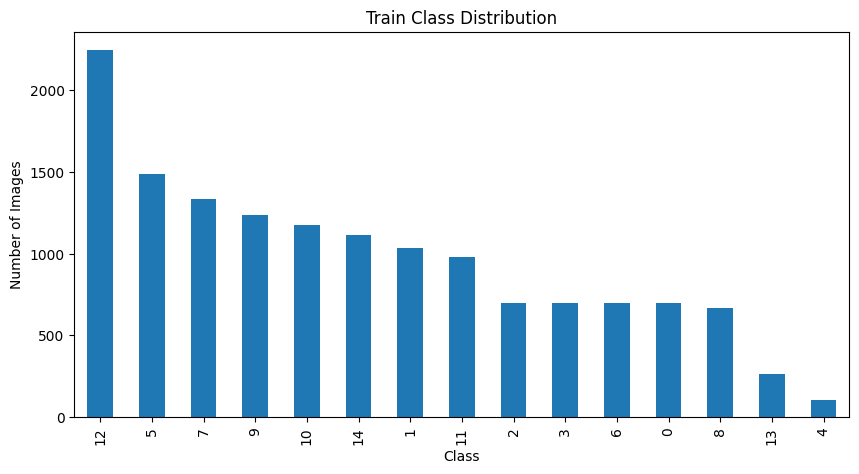

In [ ]:
train_distribution = pd.Series(train_dataset.classes).value_counts()
print(train_distribution)

train_distribution.plot(kind='bar', figsize=(10,5), title="Train Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(768, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(15, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,758,351 (18.15 MB)

 Trainable params: 2,500,367 (9.54 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint.keras', monitor='val_loss', save_best_only=True, mode='min')

history = model.fit(train_dataset, validation_data=val_dataset, epochs=25, callbacks=[earlystopping, learning_rate, checkpoint])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 855s 2s/step - accuracy: 0.6468 - loss: 1.1014 - val_accuracy: 0.8482 - val_loss: 0.4660 - learning_rate: 0.0010
Epoch 2/25
  9/452 ━━━━━━━━━━━━━━━━━━━━ 11:32 2s/step - accuracy: 0.8432 - loss: 0.5874

KeyboardInterrupt: 